# Analysis of the scRNA-seq immune cells from adipocyte tissue

## Table of contents:

* <a href=#Load>Load Packages and Set Global Variables</a>
    * <a href=#Imports>Imports and Settings</a>
    * <a href=#Global>Global Variables</a> 
* <a href=#Dataloading>Loading Data, Quality Control and Preprocessing</a>
    * <a href=#Counts>Gene numbers and counts with and without mitochondrial RNA</a>
* <a href=#Allcells>All cells - normalization, projection and clustering</a>
* <a href=#Define>Define Cell Types</a>
* <a href=#astrocytes>Astrocytes Only</a>
    * <a href=#Embedding>Embeddings and Clustering</a>
    * <a href=#adipmarkers>Astrocyte Marker Analysis</a>
    * <a href=#topde>Top ranking DE Genes</a>
    * <a href=#count_dist>Count distribution for Gfap, Aldh1l1 and Slc1a3</a>
* <a href=#traject>Gfap and Aldh1l1 only</a>

# Load Packages and Set Global Variables

<a id="imports"></a>

## Imports and Settings

In [1]:
import numpy as np
import scanpy as sc
import scipy as sci
import scipy.sparse
import pandas as pd
import seaborn as sb
import scvelo as scv
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from gprofiler import GProfiler
import custom_functions as cf
from matplotlib_venn import venn3_unweighted
from scipy import stats
import pingouin as pg
import matplotlib_venn
import statistics
import gseapy
import sys
import re
import os

import batchglm
import diffxpy.api as de

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2
sc.settings.verbosity=3 # amount of output

base_dir='/Users/viktorian.miok/Documents/consultation/Xiaocheng/'
dat_start='/Users/viktorian.miok/Documents/consultation/Altun-Ussar/data/'
dat_end='/count_matrices/filtered_gene_bc_matrices/mm10_ensrel94/'
dir_out='/Users/viktorian.miok/Documents/consultation/Xiaocheng/results/'
dir_tables=dir_out+'tables/'
sc_settings_figdir=dir_out+'figures/'
sc_settings_writedir=dir_out+'anndata/'
sc.logging.print_versions()
os.chdir(dir_out)
sc.settings.set_figure_params(dpi=80, scanpy=True)
print (sys.version)

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
PyObjCTools         NA
anndata             0.7.5
appdirs             1.4.4
appnope             0.1.2
autoreload          NA
backcall            0.2.0
batchglm            v0.7.4
bioservices         1.7.11
bs4                 4.9.3
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
colorlog            NA
custom_functions    NA
cycler              0.10.0
cython_runtime      NA
dask                2021.03.0
dateutil            2.8.1
decorator           4.4.2
diffxpy             v0.7.4
docutils            0.16
easydev             0.11.0
get_version         2.1
gprofiler           1.0.0
gseapy              0.10.4
h5py                3.2.1
idna                2.10
igraph              0.9.0
ipykernel           5.4.3
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.17.2
joblib              1.0.1


In [2]:
#Define a nice colour map for gene expression
colors2=plt.cm.Reds(np.linspace(0, 1, 128))
colors3=plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb=np.vstack([colors3, colors2])
mymap=colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)
sc.set_figure_params(scanpy=True, fontsize=17)

## Global Variables

All embeddings and clusterings can be saved and loaded into this script. Be carful with overwriting cluster caches as soon as cell type annotation has started as cluster labels may be shuffled.

Set whether anndata objects are recomputed or loaded from cache.

In [3]:
bool_recomp=False

Set whether clustering is recomputed or loaded from saved .obs file. Loading makes sense if the clustering changes due to a change in scanpy or one of its dependencies and the number of clusters or the cluster labels change accordingly.

In [4]:
bool_recluster=False

Set whether velocity is recomputed or loaded from saved .obs file.

In [5]:
bool_revelocity=False

Set whether cluster cache is overwritten. Note that the cache exists for reproducibility of clustering, see above.

In [6]:
bool_write_cluster_cache=False

Set whether to produce plots, set to False for test runs.

In [7]:
bool_plot=False

Set whether to produce only curently interesting plots for ploting

In [8]:
bool_plot_current=True

Set whether observations should be calculated. If false, it is necessary to read cacheed file that contains the necssary information. It then shows the the distributions of counts and genes, as well as mt_frac after filtering. 
Set to true in order to see the data before filtering and follow the decisions for cutoffs.

In [9]:
bool_create_observations=True

<a id="Dataloading"></a>

# Loading Data, Quality Control and Preprocessing

Read the data in:

In [10]:
if bool_recomp:
    adata87 = sc.read_10x_mtx(path=dat_start+'MUC8387'+dat_end, 
                              var_names='gene_symbols',
                              cache=True
    )  
    adata87_loom = scv.read(dat_start+'MUC8387/possorted_genome_bam_4O74Q.loom',
                            cache=True
    )
    adata87_v = scv.utils.merge(adata87, 
                                adata87_loom
    )
    ########
    adata88 = sc.read_10x_mtx(path=dat_start+'MUC8388'+dat_end,
                              var_names='gene_symbols',
                              cache=True
    )  
    adata88_loom = scv.read(dat_start+'MUC8388/possorted_genome_bam_FGFK8.loom', 
                            cache=True
    )
    adata88_v = scv.utils.merge(adata88, 
                                adata88_loom
    )
    ########
    adata89 = sc.read_10x_mtx(path=dat_start+'MUC8389'+dat_end,
                              var_names='gene_symbols',
                              cache=True
    )  
    adata89_loom = scv.read(dat_start+'MUC8389/possorted_genome_bam_ASNXU.loom',
                            cache=True
    )
    adata89_v = scv.utils.merge(adata89, 
                                adata89_loom
    )
    ########
    adata90 = sc.read_10x_mtx(path=dat_start+'MUC8390'+dat_end,
                              var_names='gene_symbols',
                              cache=True
    ) 
    adata90_loom = scv.read(dat_start+'MUC8390/possorted_genome_bam_J89SC.loom',
                            cache=True
    )
    adata90_v = scv.utils.merge(adata90, 
                                adata90_loom
    )
    ########
    adataY = sc.read_10x_mtx(path=dat_start+'PreYoung'+dat_end, 
                             var_names='gene_symbols', 
                             cache=True
    ) 
    adataY_loom = scv.read(dat_start+'PreYoung/possorted_genome_bam_VP0VC.loom',
                           cache=True
    )
    adataY_v = scv.utils.merge(adataY,
                               adataY_loom
    )
    ########
    adataO = sc.read_10x_mtx(path=dat_start+'PreOld'+dat_end,
                             var_names='gene_symbols',
                             cache=True
    ) 
    adataO_loom = scv.read(dat_start+'PreOld/possorted_genome_bam_SPR8G.loom',
                           cache=True
    )
    adataO_v = scv.utils.merge(adataO, 
                               adataO_loom
    )
    ########
    adata_raw=adata87_v.concatenate(adata88_v,
                                    adata89_v, 
                                    adata90_v, 
                                    adataY_v,
                                    adataO_v
    )

    p = adata_raw.obs_names.str.endswith
    groups=['BAT-2', 'BAT-8', 'PGF-2', 'PGF-8', 'SCF-2', 'SCF-8']
    adata_raw.obs['batch_type'] = np.select([p('-0'), p('-1'), p('-2'), p('-3'), p('-4'), p('-5')],
                                            groups
    )
    adata_raw.obs['tissue_type'] = np.select([(p('-0')|p('-1')), (p('-2')|p('-3')), (p('-4')|p('-5'))],
                                             ['BAT', 'PGF', 'SCF']
    )
    adata_raw.obs['age_type'] = np.select([(p('-0')|p('-2')|p('-4')), (p('-1')|p('-3')|p('-5'))], 
                                          ['young', 'old'])

    adata_raw.var_names_make_unique()
    sc.write(sc_settings_writedir+'adata_raw.h5ad', adata_raw)
else:
    adata_raw=sc.read(sc_settings_writedir+'adata_raw.h5ad')

Summary of steps performed here: Only cells with at least 500 UMIs are kept. Counts per cell are cell library depth normalized. The gene (feature) space is reduced with PCA to 50 PCs. A nearest neighbour graph and umap are computed based on the PC space. Cell are clustered with louvain clustering based on the nearest neighbour graph. Graph abstraction is computed based on the louvain clustering.

In [11]:
sc.pp.filter_cells(adata_raw, min_counts=1)

The data contains 21143 observations with 31253 different genes. Due to dropouts, some of the observations might not show any counts and genes. In order to calculate the fraction of mitochondrial RNA in the next steps, each observations without counts must be filtered out to prevent NaN from emerging. 

In [12]:
print('Number of cells: {:d}'.format(adata_raw.n_obs))
print('Number of genes: {:d}'.format(adata_raw.shape[1]))
print('Number of cells per tissue_type:')
adata_raw.obs['tissue_type'].value_counts().sort_index()

Number of cells: 24733
Number of genes: 31125
Number of cells per tissue_type:


BAT    6472
PGF    8917
SCF    9344
Name: tissue_type, dtype: int64

### Gene numbers and counts with and without mitochondrial RNA

Create necessary obs:

In [13]:
adata_qc=adata_raw.copy()
adata_qc.obs['n_genes']=(adata_qc.X > 0).sum(1)
mt_gene_mask=[gene.startswith('mt-') for gene in adata_qc.var_names]
temp_mt_sum=adata_qc[:,mt_gene_mask].X.sum(1)
temp_mt_sum=np.squeeze(np.asarray(temp_mt_sum))
adata_qc.obs['n_counts']=adata_qc.X.sum(1)
temp_n_counts=adata_qc.obs['n_counts']
adata_qc.obs['mt_frac']=temp_mt_sum/adata_qc.obs['n_counts']

Plot n_counts and mt_frac:

In [14]:
if bool_plot == True:
    t1 = sc.pl.violin(adata_qc,
                      ['n_counts', 'n_genes', 'mt_frac'],
                      size=1, 
                      log=False,
                      jitter=3,
                      multi_panel=True
    )

In [15]:
if bool_plot==True:
    sc.pl.highest_expr_genes(adata_qc,
                             n_top=20
    ) 

Overall, the data contains a lot of observations with high fractions of mitochondrial RNA. Additionally, most observations show counts below 100, suggesting poor data quality. To further investigate the distributions counts over genes per observations, scatterplots are created:

### Number of Genes versus Number of Counts

In [16]:
if bool_plot == True:
    p1 = sc.pl.scatter(adata_qc, 
                       'n_counts', 
                       'n_genes', 
                       color='mt_frac', 
                       size=5
    )
    p2 = sc.pl.scatter(adata_qc[adata_qc.obs['n_counts'] < 5000],
                       'n_counts',
                       'n_genes', 
                       color='mt_frac',
                       size=5
    )

### Distribution of Counts and Genes

For the remaining observations, the fraction of mitochondrial RNA is generally very low and at most 20%

In [17]:
if bool_plot == True:
    p6 = sb.distplot(adata_qc.obs['n_counts'],
                     kde=False
    )
    plt.show()
    p7 = sb.distplot(adata_qc.obs['n_counts'][adata_qc.obs['n_counts'] < 5000], 
                     kde=False)
    plt.show()

In [18]:
if bool_plot == True:
    p9 = sb.distplot(adata_qc.obs['n_genes'],
                     kde=False, 
                     bins=60
    )
    plt.show()
    p10 = sb.distplot(adata_qc.obs['n_genes'][adata_qc.obs['n_genes'] < 500],
                      kde=False,
                      bins=60
    )
    plt.show()

### Filtering

In [19]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata_qc.n_obs))

sc.pp.filter_cells(adata_qc,
                   min_counts=1500
)
print('Number of cells after min count filter: {:d}'.format(adata_qc.n_obs))

sc.pp.filter_cells(adata_qc,
                   max_counts=25000
)
print('Number of cells after max count filter: {:d}'.format(adata_qc.n_obs))

adata_qc = adata_qc[adata_qc.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata_qc.n_obs))

sc.pp.filter_cells(adata_qc, 
                   min_genes=300
)
print('Number of cells after gene filter: {:d}'.format(adata_qc.n_obs))

filtered out 701 cells that have less than 1500 counts


Total number of cells: 24733


filtered out 66 cells that have more than 25000 counts


Number of cells after min count filter: 24032
Number of cells after max count filter: 23966
Number of cells after MT filter: 23939


filtered out 1279 cells that have less than 300 genes expressed
Trying to set attribute `.obs` of view, copying.


Number of cells after gene filter: 22660


In [20]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata_qc.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_qc, 
                   min_cells=30
)
print('Number of genes after cell filter: {:d}'.format(adata_qc.n_vars))

Total number of genes: 31125


filtered out 14148 genes that are detected in less than 30 cells


Number of genes after cell filter: 16977


In [21]:
if bool_plot == True:
    p1 = sc.pl.scatter(adata_qc, 
                       'n_counts',
                       'n_genes',
                       color='mt_frac',
                       size=5
    )
    p3 = sc.pl.scatter(adata_qc[adata_qc.obs['n_counts'] < 5000],
                       'n_counts',
                       'n_genes',
                       color='mt_frac', 
                       size=5
    )

In [22]:
print('Number of cells: {:d}'.format(adata_qc.n_obs))
print('Number of genes: {:d}'.format(adata_qc.shape[1]))
print('Number of cells per tissue_type:')
adata_qc.obs['batch_type'].value_counts().sort_index()

Number of cells: 22660
Number of genes: 16977
Number of cells per tissue_type:


BAT-2    2658
BAT-8    2343
PGF-2    6303
PGF-8    2128
SCF-2    3892
SCF-8    5336
Name: batch_type, dtype: int64

## All cells - normalization, projection and clustering

Remove BAT cells and perform the standard analysis

In [23]:
if bool_recomp == True:
    adata_qc=adata_qc[adata_qc.obs['tissue_type'] != 'BAT',:] # remove brown adiopoytes
    adata_proc=adata_qc.copy()
    adata_proc.raw=adata_qc
    sc.pp.normalize_per_cell(adata_proc)
    sc.pp.log1p(adata_proc)
    sc.pp.combat(adata_proc, 
                 key='batch'
    )
    sc.pp.highly_variable_genes(adata_proc,
                                flavor='cell_ranger',
                                n_top_genes=4000
    )
    sc.pl.highly_variable_genes(adata_proc)
    #adata_proc.X=adata_proc.X.toarray()
    
    sc.pp.pca(adata_proc,
              n_comps=50,
              random_state=0, 
              use_highly_variable=True,
              svd_solver='arpack'
    )
    sc.pp.neighbors(adata_proc,
                    n_neighbors=100,
                    knn=True, 
                    method='umap',
                    n_pcs=50, 
                    random_state=0
    )
    sc.tl.umap(adata_proc)
    if bool_recluster == True:
        #sc.tl.louvain(adata_proc,
        #              resolution=0.5,
        #              flavor='vtraag',
        #              random_state=0
        #)
        sc.tl.leiden(adata_proc,
                     resolution=0.5
        )
        pd.DataFrame(adata_proc.obs).to_csv(path_or_buf=sc_settings_writedir+"obs_adata_proc.csv")
    else:
        obs=pd.read_csv(sc_settings_writedir+'obs_adata_proc.csv')
        adata_proc.obs['leiden']=pd.Series(obs['leiden'].values, dtype='category')
    sc.write(sc_settings_writedir+'adata_proc.h5ad', adata_proc)
else:
    adata_proc=sc.read(sc_settings_writedir+'adata_proc.h5ad') 
sc.tl.paga(adata_proc)

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:02)


In [24]:
adata_proc.obs['batch_type'].value_counts()

PGF-2    6303
SCF-8    5336
SCF-2    3892
PGF-8    2128
Name: batch_type, dtype: int64

Produce some summarizing plots that show the global characteristics of the data.

In [25]:
if bool_plot == True:# A530016L24Rik
    plt.rcParams['figure.figsize']=[10,10]
    cf.plot_umap_marker(adata_proc,
                        ['Pdgfra'],
                        save="_pgf-scf_cells_Pdgfra",
                        use_raw=False, 
                        color_map=mymap,
                        size=50
    )

In [26]:
if bool_plot == True:# cells in the cluster 13 need to be removed Endothelial
    plt.rcParams['figure.figsize']=[10,10]
    cf.plot_umap_marker(adata_proc,
                        ['Pecam1'],
                        save="_pgf-scf_cells_Pecam1",
                        use_raw=False, 
                        color_map=mymap,
                        size=50
    )

In [27]:
if bool_plot == True:
    plt.rcParams['figure.figsize']=[10,10]
    cf.plot_umap_marker(adata_proc,
                        ['leiden'], 
                        save="_pgf-scf_cells_leiden_clustering",
                        use_raw=False, 
                        legend_loc='on data', 
                        size=50
    )

Number of cells in each cluster:

In [28]:
adata_proc.obs["leiden"].value_counts()

0     2088
1     1970
2     1732
3     1519
4     1378
5     1240
6     1216
7      864
8      765
9      759
10     758
11     632
12     516
13     480
14     468
15     415
16     274
17     161
18     147
19     114
20      98
21      65
Name: leiden, dtype: int64

In [29]:
#####################################################################################################################
if bool_plot==True:
    marker_genes_dict={'Immune cell': ['Ptprc'],
                       'Macrophage': ['Cd68','Ccl6','Adgre1','Cd14','C1qc','Lyz2'],
                       'Monocyte': ['Csf1r','Ly6c2','Lyz1','Fn1','Spn','Ccr2'],
                       'cDc': ['Itgax',],
                       'cDc1': ['Irf8','Batf3','Xcr1','Cadm1'],
                       'cDc2': ['Cd209a','Irf4','Mgl2'],
                       'Mast cell': ['Fcer1a','Kit','Il1rl1'],
                       'Granulocyte': ['Itgam'],
                       'Neutrophil': ['Ceacam1','Cxcr2','Cxcr4','Sell','Cd63'], # ,'Ly6g'
                       'T Cell': ['Cd3g','Cd3d','Cd3e'],
                       'CD4+ T Cell': ['Cd4','Sell'],
                       'CD8+ T Cell': ['Cd8a','Cd8b1'],
                       'B Cell': ['Cd19','Cd22','Ms4a1','Cd79a','Cd79b'],
                       'NK Cell': ['Klrd1','Klrc1','Ncr1','Il2rb','Klrb1c','Klrk1'],
                       'ILCs': ['Il7r','Cd200r1','Ccr6'],
    } 
    for i in list(marker_genes_dict.keys()):
        marker_genes_dict[i].sort()
        
    sc.pl.dotplot(adata=adata_proc,
                  var_names=marker_genes_dict, 
                  groupby='leiden',
                  use_raw=True, 
                  log=False, 
                  dendrogram=True, 
                  var_group_rotation=90, 
                  show=True, 
                  save="pgf-scf_cells_celltypes_markers.pdf"
    )

# Immune cells

## Embedding and Clustering

Remove preadipocyte, presented in the clusters: 3,7,11,5,6,13(contain also endothelial cells).
Also other non-immune(Prptc-) cells from clusters: 12,18

In [30]:
if bool_recomp == True:  
    cell_ids_imuno=np.asarray(adata_proc.obs_names)[
        [x in ['0','1','2','4','8','9','10','14','15','16','17','19','20','21']# '3','7','11','5','6','13','12','18',
         for x in np.asarray(adata_proc.obs['leiden'].values)]
    ]
    adata_imuno=adata_qc[cell_ids_imuno,:].copy()  # adata_raw
    #dat=pd.DataFrame(adata_proc.X, index=adata_proc.obs.index, columns=adata_proc.var.index)
    adata_imuno.obs['n_genes']=(adata_imuno.X > 0).sum(1)
    adata_imuno.obs['n_counts']=adata_imuno.X.sum(1)
    mt_gene_mask=[gene.startswith('mt-') for gene in adata_imuno.var_names]
    temp_mt_sum=adata_imuno[:,mt_gene_mask].X.sum(1)
    temp_mt_sum=np.squeeze(np.asarray(temp_mt_sum))
    temp_n_counts=adata_imuno.obs['n_counts']
    adata_imuno.obs['mt_frac']=temp_mt_sum/adata_imuno.obs['n_counts']
    adata_imuno.raw=adata_imuno
    sc.pp.normalize_per_cell(adata_imuno)
    sc.pp.log1p(adata_imuno)
    sc.pp.highly_variable_genes(adata_imuno, n_top_genes=4000)
    #sc.pl.highly_variable_genes(adata_imuno)
    adata_imuno.X=adata_imuno.X.toarray()
    
    sc.pp.pca(adata_imuno,
              n_comps=50,
              use_highly_variable = True,
              random_state=0, 
              svd_solver='arpack'
    )
    sc.pp.neighbors(adata_imuno,
                    n_neighbors=100,
                    knn=True, 
                    method='umap',
                    n_pcs=50, 
                    random_state=0
    )
    sc.tl.umap(adata_imuno)
    
    if bool_recluster == True:
        sc.tl.leiden(adata_imuno, 
                     resolution=0.5
        )
        pd.DataFrame(adata_imuno.obs).to_csv(path_or_buf=sc_settings_writedir+'obs_adata_imuno.csv')
    else:
        obs=pd.read_csv(sc_settings_writedir+'obs_adata_imuno.csv')
        adata_imuno.obs['leiden']=pd.Series(obs['leiden'].values, dtype = 'category')
    sc.write(sc_settings_writedir+'adata_imuno.h5ad', adata_imuno)
else:
    adata_imuno=sc.read(sc_settings_writedir+'adata_imuno.h5ad') 
sc.tl.paga(adata_imuno)

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)


In [31]:
if bool_plot == True:
    cf.plot_umap_marker(adata_imuno, 
                        ['leiden'],
                        save="_immuno_cells_leiden",
                        use_raw=False,
                        size=40,
                        legend_loc='on data'
    ) 

In [32]:
if bool_plot == True:
    cf.plot_umap_marker(adata_imuno, 
                        ['batch_type'],
                        save="_immuno_cells_tissue",
                        use_raw=False,
                        size=40
    ) 

In [33]:
if bool_plot == True:
    plt.rcParams['figure.figsize']=[10,10]
    sc.pl.paga(adata_imuno,
               color=['batch_type'],
               node_size_scale=10,
               edge_width_scale=2,
               save="_immuno_cells_leiden"
    )

## Define Cell Types

<a id="DE"></a>

### Summary heatmap, dotplot and stacked_violin for cluster assignments

In [34]:
#####################################################################################################################
if bool_plot==True:
    marker_genes_dict={'Immune cell': ['Ptprc'],
                       'Macrophage': ['Adgre1','Cd14','C1qc','Mrc1','Pf4'],
                       'Inflammatory Macrophage': ['Tnf','Mmp3','Mmp9'],
                       'Perivascular Macrophage': ['Cd163','Lyve1'],
                       'Lipid-associated Macrophage': ['Trem2','Ctsb','Cd36','Ctsl','Lgals1','Lipa','Rhoc','Cd68',
                                                       'Pld3','Plin2','Serpinb6a','Cd63','Ms4a7'],
                       'Monocyte': ['Csf1r','Lyz2','Lyz1','Fn1','Ear2','Csf3r'],
                       'Classical Monocyte': ['Ly6c1','Ccr2'],
                       'Intermediate Monocyte': ['Ccr5'],
                       'Non-classical Monocyte': ['Pag1','Fpr2','Cx3cr1','Fcgr4','Il1b','Lst1','Treml4'],
                       'cDc': ['Itgax',],
                       'cDc1': ['Irf8','Batf3','Xcr1','Cadm1'],
                       'cDc2': ['Cd209a','Irf4','Mgl2','Clec10a','Ccr7','Fscn1'],                        
                       'Mast cell': ['Fcer1a','Kit','Il1rl1'],                         
                       'Myeloid cells': ['Itgam'], 
                       'Neutrophil': ['S100a8','Cxcr2','Cxcr4','Sell','S100a9','Ly6g'],                                             
                       'T Cell': ['Cd3g','Cd3d','Cd3e'],
                       'Naïve T Cell': ['Sell','Ccr7'],
                       'CD4+/CD8+ T Cell': ['Cd2','Cd4','Cd40lg','Cd8a','Cd8b1','Foxp3','Ctla4','Nkg7','Gzmb','Gzmk'], 
                       'MAIT': ['Cd44','Rorc','Cxcr6','Zbtb16','Ccr6','Il17a','Il23r'],                         
                       'B Cell': ['Cd19','Cd22','Ms4a1','Cd79a','Cd79b','Ly6d'],                         
                       'NK Cell': ['Klrd1','Klrc1','Ncr1','Il2rb','Klrb1c','Klrk1'],                         
                       'ILCs': ['Il7r','Cd200r1','Gata3','Ly6a','Il1rl1','Il5','Il13']

    } 
    for i in list(marker_genes_dict.keys()):
        marker_genes_dict[i].sort()
        
    sc.pl.dotplot(adata=adata_imuno,
                  var_names=marker_genes_dict, 
                  groupby='leiden',
                  use_raw=True, 
                  log=False, 
                  dendrogram=True, 
                  var_group_rotation=90, 
                  show=True, 
                  #size_title=5,
                  save="immuno_cells_celltypes_markers.pdf"
    )

## Differential gene expression - immuno cells - clusters

In [35]:
if bool_plot == True: 
    #adata_imuno1 = adata_imuno[:, adata_imuno.var.highly_variable] # Keep only top 4000
    sc.tl.rank_genes_groups(adata_imuno, 
                            'leiden',
                            use_raw=False,
                            method='t-test'
    )  
    # Build the 
    result = adata_imuno.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    df = pd.DataFrame({group + '_' + key[:1]: result[key][group]
                   for group in groups for key in ['names', 'logfoldchanges', 'pvals_adj']}
    )
    df.to_csv("tables/DGE_imuno_clusters.csv")

## UMAP with assigned cell types

In [36]:
if bool_plot == True:
    new_cluster_names = {'0': "B cell",
                         '1': "Macrophages",
                         '2': "Monocytes",
                         '3': "CD4+/CD8+ T Cells",
                         '4': "Naïve T Cell",
                         '5': "Non-classical Monocyte",
                         '6': "NK cells",
                         '7': "cDC2B",
                         '8': "cDC1",
                         '9': "ILCs",
                         '10': "Perivascular Macrophage",
                         '11': "MAIT",
                         '12': "Mast cell",
                         '13': "cDC2A",
                         '14': "Neutrophil"
    }
    adata_imuno.obs['celltypes'] = [new_cluster_names[x] for x in  adata_imuno.obs['leiden']]
    plt.rcParams['figure.figsize']=[10,10]
    cf.plot_umap_marker(adata_imuno, 
                        ['celltypes'], 
                        save="_immuno_cells_celltypes",
                        use_raw=False, 
                        frameon=True, 
                        size=50,
                        title=''
    ) 

In [37]:
if bool_plot == True:
    cf.cell_percent(adata_imuno, 
                    'celltypes', 
                    'batch_type',
                    ['tab:blue','tab:orange','tab:green','tab:red'],
                    norm='index',
                    xlabel='', 
                    ylabel='Percentage of cells',
                    leg_loc='upper left',
                    title='',
                    save='figures/percent_immuno_celltype_tissue', 
                    table=False
    )
    pd_celltypes = pd.crosstab(adata_imuno.obs['celltypes'],
                               adata_imuno.obs['batch_type'], 
                               normalize=False,
                               margins=True
    )
    pd_celltypes.to_csv('tables/number_cell_immuno_celltype_tissue.csv')

# WAT monocytes and macrophages

## Embedding and Clustering

In [38]:
if bool_recomp == True:  
    cell_ids_mm=np.asarray(adata_imuno.obs_names)[
        [x in ['1','2','5','10']
         for x in np.asarray(adata_imuno.obs['leiden'].values)]
    ]
    adata_mm=adata_imuno[cell_ids_mm,:].copy()  # adata_raw
    adata_mm.obs['n_genes']=(adata_mm.X > 0).sum(1)
    adata_mm.obs['n_counts']=adata_mm.X.sum(1)
    mt_gene_mask=[gene.startswith('mt-') for gene in adata_mm.var_names]
    temp_mt_sum=adata_mm[:,mt_gene_mask].X.sum(1)
    temp_mt_sum=np.squeeze(np.asarray(temp_mt_sum))
    temp_n_counts=adata_mm.obs['n_counts']
    adata_mm.obs['mt_frac']=temp_mt_sum/adata_mm.obs['n_counts']
    adata_mm.raw=adata_mm
    sc.pp.normalize_per_cell(adata_mm)
    sc.pp.log1p(adata_mm)
    sc.pp.highly_variable_genes(adata_mm, n_top_genes=4000)
    #sc.pl.highly_variable_genes(adata_mm)
    #adata_mm.X=adata_mm.X.toarray()
    
    sc.pp.pca(adata_mm,
              n_comps=50,
              use_highly_variable = True,
              random_state=0, 
              svd_solver='arpack'
    )
    sc.pp.neighbors(adata_mm,
                    n_neighbors=100,
                    knn=True, 
                    method='umap',
                    n_pcs=50, 
                    random_state=0
    )
    sc.tl.umap(adata_mm)
    
    if bool_revelocity == True:
        scv.pp.moments(adata_mm, 
                       n_pcs=30,
                       n_neighbors=30
        )
        scv.tl.recover_dynamics(adata_mm, 
                                n_jobs=8
        )
        scv.tl.velocity(adata_mm)
        scv.tl.velocity_graph(adata_mm)
        scv.tl.latent_time(adata_mm)
        
    if bool_recluster == True:
        sc.tl.leiden(adata_mm, 
                     resolution=0.5, 
                     key_added='leiden_mm'
        )
        pd.DataFrame(adata_mm.obs).to_csv(path_or_buf=sc_settings_writedir+'obs_adata_mm.csv')
    else:
        obs=pd.read_csv(sc_settings_writedir+'obs_adata_mm.csv')
        adata_mm.obs['leiden_mm']=pd.Series(obs['leiden_mm'].values, dtype = 'category')
    sc.write(sc_settings_writedir+'adata_mm.h5ad', adata_mm)
else:
    adata_mm=sc.read(sc_settings_writedir+'adata_mm.h5ad') 
sc.tl.paga(adata_mm)

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


['leiden_mm']


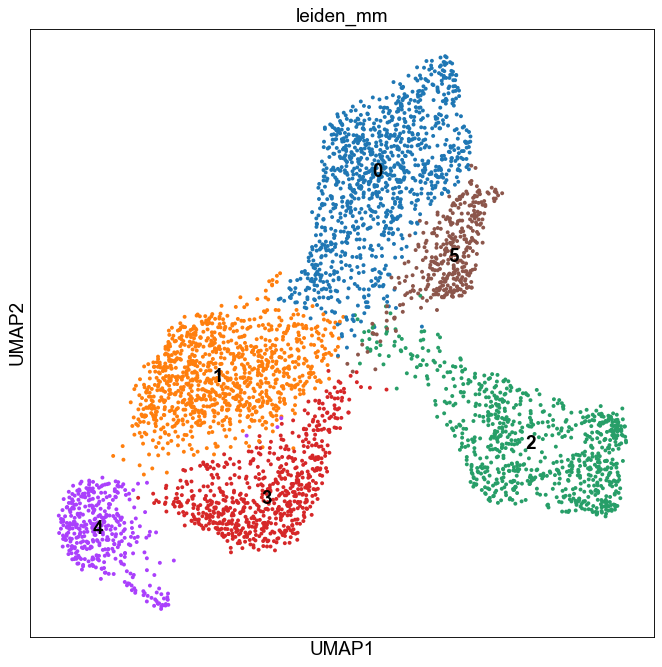

In [39]:
if bool_plot_current == True:
    plt.rcParams['figure.figsize']=[10,10]
    cf.plot_umap_marker(adata_mm,
                        ['leiden_mm'], 
                        save="_mm_cells_leiden_clustering",
                        use_raw=False, 
                        legend_loc='on data', 
                        size=50
    )

## Cluster cell type 

In [40]:
#####################################################################################################################
if bool_plot==True:
    marker_genes_dict={'Monocyte': ['Lyz1','Fn1','Ear2','Csf3r'],
                       'Classical Monocyte': ['Ly6c1','Ccr2'],
                       'Intermediate Monocyte': ['Ccr5'],
                       'Non-classical Monocyte': ['Pag1','Fpr2','Cx3cr1','Fcgr4','Il1b','Lst1','Treml4'],
                       'Macrophage': ['Adgre1','Cd14','C1qc','Mrc1','Pf4'],
                       'Inflammatory Macrophage': ['Tnf','Mmp3','Mmp9'],
                       'Perivascular Macrophage': ['Cd163','Lyve1'],
                       'Lipid-associated Macrophage': ['Trem2','Ctsb','Cd36','Ctsl','Lgals1','Lipa','Rhoc','Cd68',
                                                       'Pld3','Plin2','Serpinb6a','Cd63','Ms4a7']
    } 
    for i in list(marker_genes_dict.keys()):
        marker_genes_dict[i].sort()
    
    sc.pl.dotplot(adata=adata_mm,
                  var_names=marker_genes_dict, 
                  groupby='leiden_mm',
                  use_raw=True, 
                  log=False, 
                  dendrogram=True, 
                  var_group_rotation=90, 
                  show=True, 
                  #size_title=5,
                  save="mm_cells_celltypes_markers.pdf"
    )

## UMAP with assigned cell types

In [41]:
#####################################################################################################################
if bool_plot == True:
    new_cluster_names = {'0': "Intermediate Monocyte",
                         '1': "Lipid-associated Macrophage",
                         '2': "Non-classical Monocyte",
                         '3': "Inflammatory Macrophage",
                         '4': "Perivascular Macrophage",
                         '5': "Classical Monocyte",
    }
    adata_mm.obs['celltypes'] = [new_cluster_names[x] for x in  adata_mm.obs['leiden_mm']]
    plt.rcParams['figure.figsize']=[10,10]
    cf.plot_umap_marker(adata_mm, 
                        ['celltypes'], 
                        palette=['tab:brown','tab:Red','tab:blue','tab:orange','tab:green','tab:purple'],
                        save="_mm_cells_celltypes.pdf",
                        use_raw=False, 
                        frameon=True, 
                        size=50,
                        title=''
    ) 

## Differential gene expression - clusters

In [42]:
if bool_plot == True: 
    #adata_imuno1 = adata_imuno[:, adata_imuno.var.highly_variable] # Keep only top 4000
    sc.tl.rank_genes_groups(adata_mm, 
                            'leiden_mm',
                            use_raw=False,
                            method='t-test'
    )  
    # Build the data frame
    result = adata_mm.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    df = pd.DataFrame({group + '_' + key[:1]: result[key][group]
                   for group in groups for key in ['names', 'logfoldchanges', 'pvals_adj']}
    )
    df.to_csv("tables/DGE_mm_clusters.csv")

## RNA velocity

In [43]:
if bool_plot == True:
    scv.pl.velocity_embedding_stream(adata_mm,
                                     basis='umap', 
                                     color='leiden_mm',
                                     use_raw=False, 
                                     size=60, 
                                     figsize=(10,10), 
                                     legend_loc='on data',
                                     save="mm_cells_clust_velocity.svg"
    ) 

## Latent time

The dynamical model recovers the latent time of the underlying cellular processes. This latent time represents the cell’s internal clock and approximates the real time experienced by cells as they differentiate, based only on its transcriptional dynamics.

In [44]:
if bool_plot == True:
    kwargs = dict(color='latent_time',
                  color_map='gnuplot',
                  title='',
                  vmin=-.1,
                  colorbar=False,
                  show=False
    )
    ax = scv.pl.velocity_embedding(adata_mm, 
                                   arrow_length=4,
                                   arrow_size=1.5,
                                   alpha=.5, 
                                   dpi=150,
                                   **kwargs
    )
    ax = scv.pl.velocity_embedding_stream(adata_mm,
                                          size=150,
                                          alpha=.01,
                                          arrow_color='white',
                                          ax=ax,
                                          smooth=.7,
                                          min_mass=3.5, 
                                          density=.6, 
                                          linewidth=.6, 
                                          **kwargs
    )
    ax = scv.pl.velocity_embedding_stream(adata_mm,
                                          size=150, 
                                          alpha=.1,
                                          arrow_color='darkslategrey', 
                                          ax=ax,
                                          smooth=.7, 
                                          min_mass=3.5,
                                          density=.6,
                                          linewidth=.5,
                                          save="mm_cells_latentTime_velocity.svg",
                                          **kwargs
    )

In [45]:
if bool_plot == True:
    var_names = adata_mm.var.sort_values('fit_likelihood', ascending=False).index[:300]
    scv.pl.heatmap(adata_mm,
                   var_names=var_names,
                   tkey='latent_time',
                   n_convolve=100, 
                   col_color='leiden_mm',
                   save='mm_cells_heatmap_latentTime.pdf'
    )
    # save table of top dynamical genes
    scv.tl.rank_dynamical_genes(adata_mm,
                                groupby='leiden_mm'
    )
    df = scv.get_df(adata_mm, 
                    'rank_dynamical_genes/names'
    )
    df.to_csv('tables/mm_rank_dynamical_genes.csv')

## Diffusion Pseudotime

Finally, we include Diffusion Pseudotime in the analysis to further support the found trajectories. Diffusion pseudotime is integrated into scanpy and is therefore easy to use with the current setup.

DPT is based on diffusion maps, thus a diffusion map representation must be calculated prior to pseudotime inference. This in turn is based on a KNN graph embedding obtained from `sc.pp.neighbors()`.

In [46]:
if bool_plot == True:
    sc.pp.neighbors(adata_mm)
    sc.tl.diffmap(adata_mm)

    mm_mask21 = np.isin(adata_mm.obs['leiden_mm'], '0')
    max_mm_id21 = np.argmax(adata_mm.obsm['X_diffmap'][mm_mask21,2])
    root_id21 = np.arange(len(mm_mask21))[mm_mask21][max_mm_id21]
    adata_mm.uns['iroot'] = root_id21

    #Compute dpt
    sc.tl.dpt(adata_mm, n_branchings = 0)

    cf.plot_diffmap_marker(adata_mm,
                           ['leiden_mm','age_type','tissue_type','dpt_pseudotime'],
                           components='1,2', 
                           color_map=mymap, 
                           use_raw=False,
                           size=20,
                           save="_mm_cells"
    )

# WAT effector lymphocytes  

## Embedding and Clustering

In [47]:
if bool_recomp == True:  
    cell_ids_lymph=np.asarray(adata_imuno.obs_names)[
        [x in ['3','4','6','9','11']
         for x in np.asarray(adata_imuno.obs['leiden'].values)]
    ]
    adata_lymph=adata_imuno[cell_ids_lymph,:].copy()  # adata_raw
    adata_lymph.obs['n_genes']=(adata_lymph.X > 0).sum(1)
    adata_lymph.obs['n_counts']=adata_lymph.X.sum(1)
    mt_gene_mask=[gene.startswith('mt-') for gene in adata_lymph.var_names]
    temp_mt_sum=adata_lymph[:,mt_gene_mask].X.sum(1)
    temp_mt_sum=np.squeeze(np.asarray(temp_mt_sum))
    temp_n_counts=adata_lymph.obs['n_counts']
    adata_lymph.obs['mt_frac']=temp_mt_sum/adata_lymph.obs['n_counts']
    adata_lymph.raw=adata_lymph
    sc.pp.normalize_per_cell(adata_lymph)
    sc.pp.log1p(adata_lymph)
    sc.pp.highly_variable_genes(adata_lymph, n_top_genes=4000)
    #sc.pl.highly_variable_genes(adata_lymph)
    #adata_lymph.X=adata_lymph.X.toarray()
    
    sc.pp.pca(adata_lymph,
              n_comps=50,
              use_highly_variable = True,
              random_state=0, 
              svd_solver='arpack'
    )
    sc.pp.neighbors(adata_lymph,
                    n_neighbors=100,
                    knn=True, 
                    method='umap',
                    n_pcs=50, 
                    random_state=0
    )
    sc.tl.umap(adata_lymph)
    
    if bool_revelocity == True:
        scv.pp.moments(adata_lymph, 
                       n_pcs=30,
                       n_neighbors=30
        )
        scv.tl.recover_dynamics(adata_lymph, 
                                n_jobs=8
        )
        scv.tl.velocity(adata_lymph)
        scv.tl.velocity_graph(adata_lymph)
        scv.tl.latent_time(adata_lymph)
        
    if bool_recluster == True:
        sc.tl.leiden(adata_lymph, 
                     resolution=0.5,
                     key_added='leiden_lymph')
        pd.DataFrame(adata_lymph.obs).to_csv(path_or_buf=sc_settings_writedir+'obs_adata_lymph.csv')
    else:
        obs=pd.read_csv(sc_settings_writedir+'obs_adata_lymph.csv')
        adata_lymph.obs['leiden_lymph']=pd.Series(obs['leiden_lymph'].values, dtype = 'category')
    sc.write(sc_settings_writedir+'adata_lymph.h5ad', adata_lymph)
else:
    adata_lymph=sc.read(sc_settings_writedir+'adata_lymph.h5ad') 
sc.tl.paga(adata_lymph)

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


In [48]:
if bool_plot == True:
    plt.rcParams['figure.figsize']=[10,10]
    cf.plot_umap_marker(adata_lymph,
                        ['leiden_lymph'], 
                        save="_lymph_cells_leiden_clustering",
                        use_raw=False, 
                        legend_loc='on data', 
                        size=50
    )

## Cluster cell type 

In [49]:
#####################################################################################################################
if bool_plot == True:
    marker_genes_dict={'T Cell': ['Cd3g','Cd3d','Cd3e'],
                       'Naïve T Cell': ['Sell','Ccr7'],
                       'CD4+/CD8+ T Cell': ['Cd4','Cd40lg','Cd8a','Cd8b1','Foxp3','Ctla4','Nkg7','Gzmb','Gzmk'], 
                       'MAIT': ['Cd44','Rorc','Cxcr6','Zbtb16','Ccr6','Il17a','Il23r'],                         
                       'NK Cell': ['Klrd1','Klrc1','Ncr1','Il2rb','Klrb1c','Klrk1'],
                       'ILCs': ['Il7r','Cd200r1','Gata3','Ly6a','Il1rl1','Il5','Il13']
    } 
    for i in list(marker_genes_dict.keys()):
        marker_genes_dict[i].sort()
        
    sc.pl.dotplot(adata=adata_lymph,
                  var_names=marker_genes_dict, 
                  groupby='leiden_lymph',
                  use_raw=True, 
                  log=False, 
                  dendrogram=True, 
                  var_group_rotation=90, 
                  show=True, 
                  #size_title=5,
                  save="lymph_cells_celltypes_markers.pdf"
    )

## UMAP with assigned cell types

In [50]:
#####################################################################################################################
if bool_plot == True:
    new_cluster_names = {'0': "CD4+/CD8+ T Cell",
                         '1': "Naïve T Cell",
                         '2': "NK Cell",
                         '3': "ILCs",
                         '4': "MAIT"
    }
    adata_lymph.obs['celltypes'] = [new_cluster_names[x] for x in  adata_lymph.obs['leiden_lymph']]
    plt.rcParams['figure.figsize']=[10,10]
    cf.plot_umap_marker(adata_lymph, 
                        ['celltypes'], 
                        palette=['tab:blue','tab:Red','tab:purple','tab:green','tab:orange'],
                        save="_lymph_cells_celltypes",
                        use_raw=False, 
                        frameon=True, 
                        size=50,
                        title=''
    ) 

## Differential gene expression - clusters

In [51]:
if bool_plot == True: 
    #adata_imuno1 = adata_imuno[:, adata_imuno.var.highly_variable] # Keep only top 4000
    sc.tl.rank_genes_groups(adata_lymph, 
                            'leiden_lymph',
                            use_raw=False,
                            method='t-test'
    )  
    # Build the 
    result = adata_lymph.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    df = pd.DataFrame({group + '_' + key[:1]: result[key][group]
                   for group in groups for key in ['names', 'logfoldchanges', 'pvals_adj']}
    )
    df.to_csv("tables/DGE_lymph_clusters.csv")

## RNA velocity

In [52]:
if bool_plot == True:
    scv.pl.velocity_embedding_stream(adata_lymph,
                                     basis='umap', 
                                     color='leiden_lymph',
                                     use_raw=False, 
                                     size=60, 
                                     figsize=(10,10), 
                                     legend_loc='on data', 
                                     save="lymph_cells_clust_velocity.svg"
                                     #palette=['firebrick','mediumblue','dodgerblue','aqua']
    ) 

In [53]:
if bool_plot == True:
    kwargs = dict(color='latent_time',
                  color_map='gnuplot',
                  title='',
                  vmin=-.1,
                  colorbar=False,
                  show=False
    )
    ax = scv.pl.velocity_embedding(adata_lymph, 
                                   arrow_length=4,
                                   arrow_size=1.5,
                                   alpha=.5, 
                                   dpi=150,
                                   **kwargs
    )
    ax = scv.pl.velocity_embedding_stream(adata_lymph,
                                          size=150,
                                          alpha=.01,
                                          arrow_color='white',
                                          ax=ax,
                                          smooth=.7,
                                          min_mass=3.5, 
                                          density=.6, 
                                          linewidth=.6, 
                                          **kwargs
    )
    ax = scv.pl.velocity_embedding_stream(adata_lymph,
                                          size=150, 
                                          alpha=.1,
                                          arrow_color='darkslategrey', 
                                          ax=ax,
                                          smooth=.7, 
                                          min_mass=3.5,
                                          density=.6,
                                          linewidth=.5,
                                          save="lymph_cells_latentTime_velocity.svg",
                                          **kwargs
    )

In [54]:
if bool_plot == True:
    var_names = adata_lymph.var.sort_values('fit_likelihood', ascending=False).index[:300]
    scv.pl.heatmap(adata_lymph,
                   var_names=var_names,
                   tkey='latent_time',
                   n_convolve=100, 
                   col_color='leiden_lymph',
                   save='lymph_cells_heatmap_latentTime.pdf'
    )
    # save table of top dynamical genes
    scv.tl.rank_dynamical_genes(adata_lymph,
                                groupby='leiden_lymph'
    )
    df = scv.get_df(adata_lymph, 
                    'rank_dynamical_genes/names'
    )
    df.to_csv('tables/lymph_rank_dynamical_genes.csv')

## Diffusion Pseudotime

Finally, we include Diffusion Pseudotime in the analysis to further support the found trajectories. Diffusion pseudotime is integrated into scanpy and is therefore easy to use with the current setup.

DPT is based on diffusion maps, thus a diffusion map representation must be calculated prior to pseudotime inference. This in turn is based on a KNN graph embedding obtained from `sc.pp.neighbors()`.

In [55]:
if bool_plot==True:
    
    sc.pp.neighbors(adata_lymph)
    sc.tl.diffmap(adata_lymph)

    lymph_mask21 = np.isin(adata_lymph.obs['leiden_lymph'], '1')
    max_lymph_id21 = np.argmax(adata_lymph.obsm['X_diffmap'][lymph_mask21,2])
    root_id21 = np.arange(len(lymph_mask21))[lymph_mask21][max_lymph_id21]
    adata_lymph.uns['iroot'] = root_id21

    #Compute dpt
    sc.tl.dpt(adata_lymph,
              n_branchings=0
    )

    cf.plot_diffmap_marker(adata_lymph,
                           ['leiden_lymph','age_type','tissue_type','dpt_pseudotime'],
                           components='1,2', 
                           color_map=mymap, 
                           use_raw=False,
                           size=20,
                           save="_lymph_cells"
    )

# Young - WAT monocytes and macrophages

In [56]:
# RNA velocity
if bool_recomp == True: 
    adata_mm_y=adata_mm[adata_mm.obs['age_type']=='young',]
    sc.pp.pca(adata_mm_y,
              n_comps=50,
              use_highly_variable=True,
              random_state=0, 
              svd_solver='arpack'
    )
    sc.pp.neighbors(adata_mm_y,
                    n_neighbors=100,
                    knn=True, 
                    method='umap',
                    n_pcs=50, 
                    random_state=0
    )
    sc.tl.umap(adata_mm_y)
    
    sc.tl.leiden(adata_mm_y, 
                     resolution=0.5,
                     key_added='leiden_mm_y'
    )
    scv.pp.moments(adata_mm_y, 
                   n_pcs=30,
                   n_neighbors=30
    )
    scv.tl.recover_dynamics(adata_mm_y, 
                            n_jobs=8
    )
    scv.tl.velocity(adata_mm_y)
    scv.tl.velocity_graph(adata_mm_y)
    scv.tl.latent_time(adata_mm_y)
    sc.write(sc_settings_writedir+'adata_mm_y.h5ad', adata_mm_y)
else:
    adata_mm_y = sc.read(sc_settings_writedir+'adata_mm_y.h5ad') 

In [57]:
if bool_plot == True:
    plt.rcParams['figure.figsize']=[10,10]
    cf.plot_umap_marker(adata_mm_y,
                        ['leiden_mm_y'], 
                        save="_mm_young_cells_leiden_clustering",
                        use_raw=False, 
                        legend_loc='on data', 
                        size=50
    )

## Cluster cell type 

In [58]:
#####################################################################################################################
if bool_plot==True:
    marker_genes_dict={'Monocyte': ['Lyz1','Fn1','Ear2','Csf3r'],
                       'Classical Monocyte': ['Ly6c1','Ccr2'],
                       'Intermediate Monocyte': ['Ccr5'],
                       'Non-classical Monocyte': ['Pag1','Fpr2','Cx3cr1','Fcgr4','Il1b','Lst1','Treml4'],
                       'Macrophage': ['Adgre1','Cd14','C1qc','Mrc1','Pf4'],
                       'Inflammatory Macrophage': ['Tnf','Mmp3','Mmp9'],
                       'Perivascular Macrophage': ['Cd163','Lyve1'],
                       'Lipid-associated Macrophage': ['Trem2','Ctsb','Cd36','Ctsl','Lgals1','Lipa','Rhoc','Cd68',
                                                       'Pld3','Plin2','Serpinb6a','Cd63','Ms4a7']
    } 
    for i in list(marker_genes_dict.keys()):
        marker_genes_dict[i].sort()
        
    sc.pl.dotplot(adata=adata_mm_y,
                  var_names=marker_genes_dict, 
                  groupby='leiden_mm_y',
                  use_raw=True, 
                  log=False, 
                  dendrogram=True, 
                  var_group_rotation=90, 
                  show=True, 
                  #size_title=5,
                  save="mm_young_cells_celltypes_markers.pdf"
    )

## UMAP with assigned cell types

In [59]:
if bool_plot == True:
    new_cluster_names = {'0': "Lipid-associated Macrophage",
                         '1': "Intermediate Monocyte",
                         '2': "Inflammatory Macrophage",
                         '3': "Non-classical Monocyte",
                         '4': "Perivascular Macrophage",
                         '5': "Classical Monocyte"
    }
    adata_mm_y.obs['celltypes'] = [new_cluster_names[x] for x in  adata_mm_y.obs['leiden_mm_y']]
    plt.rcParams['figure.figsize']=[10,10]
    cf.plot_umap_marker(adata_mm_y, 
                        ['celltypes'], 
                        save="_mm_young_cells_celltypes",
                        palette=['tab:brown','tab:Red','tab:blue','tab:orange','tab:green','tab:purple'],
                        use_raw=False, 
                        frameon=True, 
                        size=50,
                        title=''
    ) 

## Differential gene expression - clusters

In [60]:
if bool_plot == True: 
    #adata_imuno1 = adata_imuno[:, adata_imuno.var.highly_variable] # Keep only top 4000
    sc.tl.rank_genes_groups(adata_mm_y, 
                            'leiden_mm_y',
                            use_raw=False,
                            method='t-test'
    )  
    # Build the 
    result = adata_mm_y.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    df = pd.DataFrame({group + '_' + key[:1]: result[key][group]
                   for group in groups for key in ['names', 'logfoldchanges', 'pvals_adj']}
    )
    df.to_csv("tables/DGE_mm_young_clusters.csv")

## RNA velocity

In [61]:
if bool_plot == True:
    scv.pl.velocity_embedding_stream(adata_mm_y,
                                     basis='umap', 
                                     color='leiden_mm_y',
                                     use_raw=False, 
                                     size=60, 
                                     figsize=(10,10), 
                                     legend_loc='on data',
                                     save="mm_young_cells_clust_velocity.svg"
                                     #palette=['firebrick','mediumblue','dodgerblue','aqua']
    ) 

## Latent time

The dynamical model recovers the latent time of the underlying cellular processes. This latent time represents the cell’s internal clock and approximates the real time experienced by cells as they differentiate, based only on its transcriptional dynamics.

In [62]:
if bool_plot == True:
    kwargs = dict(color='latent_time',
                  color_map='gnuplot',
                  title='',
                  vmin=-.1,
                  colorbar=False,
                  show=False
    )
    ax = scv.pl.velocity_embedding(adata_mm_y, 
                                   arrow_length=4,
                                   arrow_size=1.5,
                                   alpha=.5, 
                                   dpi=150,
                                   **kwargs
    )
    ax = scv.pl.velocity_embedding_stream(adata_mm_y,
                                          size=150,
                                          alpha=.01,
                                          arrow_color='white',
                                          ax=ax,
                                          smooth=.7,
                                          min_mass=3.5, 
                                          density=.6, 
                                          linewidth=.6, 
                                          **kwargs
    )
    ax = scv.pl.velocity_embedding_stream(adata_mm_y,
                                          size=150, 
                                          alpha=.1,
                                          arrow_color='darkslategrey', 
                                          ax=ax,
                                          smooth=.7, 
                                          min_mass=3.5,
                                          density=.6,
                                          linewidth=.5,
                                          save="mm_young_cells_latentTime_velocity.svg",
                                          **kwargs
    )

In [63]:
if bool_plot == True:
    var_names = adata_mm_y.var.sort_values('fit_likelihood', ascending=False).index[:300]
    scv.pl.heatmap(adata_mm_y,
                   var_names=var_names,
                   tkey='latent_time',
                   n_convolve=100, 
                   col_color='leiden_mm_y',
                   save='mm_young_cells_heatmap_latentTime.pdf'
    )
    # save table of top dynamical genes
    scv.tl.rank_dynamical_genes(adata_mm_y,
                                groupby='leiden_mm_y'
    )
    df = scv.get_df(adata_mm_y, 
                    'rank_dynamical_genes/names'
    )
    df.to_csv('tables/mm_young_rank_dynamical_genes.csv')

## Diffusion Pseudotime

Finally, we include Diffusion Pseudotime in the analysis to further support the found trajectories. Diffusion pseudotime is integrated into scanpy and is therefore easy to use with the current setup.

DPT is based on diffusion maps, thus a diffusion map representation must be calculated prior to pseudotime inference. This in turn is based on a KNN graph embedding obtained from `sc.pp.neighbors()`.

In [64]:
if bool_plot == True:
    sc.pp.neighbors(adata_mm_y)
    sc.tl.diffmap(adata_mm_y)

    mm_mask21 = np.isin(adata_mm_y.obs['leiden_mm_y'], '5')
    max_mm_id21 = np.argmax(adata_mm_y.obsm['X_diffmap'][mm_mask21,2])
    root_id21 = np.arange(len(mm_mask21))[mm_mask21][max_mm_id21]
    adata_mm_y.uns['iroot'] = root_id21

    #Compute dpt
    sc.tl.dpt(adata_mm_y, n_branchings = 0)

    cf.plot_diffmap_marker(adata_mm_y,
                           ['leiden_mm_y','age_type','tissue_type','dpt_pseudotime'],
                           components='1,2', 
                           color_map=mymap, 
                           use_raw=False,
                           size=20,
                           save="_mm_young_cells"
    )

# Old - WAT monocytes and macrophages

In [65]:
# RNA velocity
if bool_recomp == True: 
    adata_mm_o=adata_mm[adata_mm.obs['age_type']=='old',]
    sc.pp.pca(adata_mm_o,
              n_comps=50,
              use_highly_variable=True,
              random_state=0, 
              svd_solver='arpack'
    )
    sc.pp.neighbors(adata_mm_o,
                    n_neighbors=100,
                    knn=True, 
                    method='umap',
                    n_pcs=50, 
                    random_state=0
    )
    sc.tl.umap(adata_mm_o)
    
    sc.tl.leiden(adata_mm_o, 
                     resolution=0.5,
                     key_added='leiden_mm_o'
    )
    scv.pp.moments(adata_mm_o, 
                   n_pcs=30,
                   n_neighbors=30
    )
    scv.tl.recover_dynamics(adata_mm_o, 
                            n_jobs=8
    )
    scv.tl.velocity(adata_mm_o)
    scv.tl.velocity_graph(adata_mm_o)
    scv.tl.latent_time(adata_mm_o)
    sc.write(sc_settings_writedir+'adata_mm_o.h5ad', adata_mm_o)
else:
    adata_mm_o = sc.read(sc_settings_writedir+'adata_mm_o.h5ad') 

In [66]:
if bool_plot == True:
    plt.rcParams['figure.figsize']=[10,10]
    cf.plot_umap_marker(adata_mm_o,
                        ['leiden_mm_o'], 
                        save="_mm_old_cells_leiden_clustering",
                        use_raw=False, 
                        legend_loc='on data', 
                        size=50
    )

## Cluster cell type 

In [67]:
#####################################################################################################################
if bool_plot == True:
    marker_genes_dict={'Monocyte': ['Lyz1','Fn1','Ear2','Csf3r'],
                       'Classical Monocyte': ['Ly6c1','Ccr2'],
                       'Intermediate Monocyte': ['Ccr5'],
                       'Non-classical Monocyte': ['Pag1','Fpr2','Cx3cr1','Fcgr4','Il1b','Lst1','Treml4'],
                       'Macrophage': ['Adgre1','Cd14','C1qc','Mrc1','Pf4'],
                       'Inflammatory Macrophage': ['Tnf','Mmp3','Mmp9'],
                       'Perivascular Macrophage': ['Cd163','Lyve1'],
                       'Lipid-associated Macrophage': ['Trem2','Ctsb','Cd36','Ctsl','Lgals1','Lipa','Rhoc','Cd68',
                                                       'Pld3','Plin2','Serpinb6a','Cd63','Ms4a7']
    } 
    for i in list(marker_genes_dict.keys()):
        marker_genes_dict[i].sort()
        
    sc.pl.dotplot(adata=adata_mm_o,
                  var_names=marker_genes_dict, 
                  groupby='leiden_mm_o',
                  use_raw=True, 
                  log=False, 
                  dendrogram=True, 
                  var_group_rotation=90, 
                  show=True, 
                  #size_title=5,
                  save="mm_old_cells_celltypes_markers.pdf"
    )

## UMAP with assigned cell types

In [68]:
if bool_plot == True:
    new_cluster_names = {'0': "Inflammatory Macrophage",
                         '1': "Intermediate Monocyte",
                         '2': "Classical Monocyte",
                         '3': "Non-classical Monocyte",
                         '4': "Lipid-associated Macrophage"
    }
    adata_mm_o.obs['celltypes'] = [new_cluster_names[x] for x in  adata_mm_o.obs['leiden_mm_o']]
    plt.rcParams['figure.figsize']=[10,10]
    cf.plot_umap_marker(adata_mm_o, 
                        ['celltypes'], 
                        palette=['tab:brown','tab:Red','tab:blue','tab:orange','tab:green'],
                        save="_mm_old_cells_celltypes",
                        use_raw=False, 
                        frameon=True, 
                        size=50,
                        title=''
    ) 

## Differential gene expression - clusters

In [69]:
if bool_plot == True: 
    #adata_imuno1 = adata_imuno[:, adata_imuno.var.highly_variable] # Keep only top 4000
    sc.tl.rank_genes_groups(adata_mm_o, 
                            'leiden_mm_o',
                            use_raw=False,
                            method='t-test'
    )  
    # Build the 
    result = adata_mm_o.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    df = pd.DataFrame({group + '_' + key[:1]: result[key][group]
                   for group in groups for key in ['names', 'logfoldchanges', 'pvals_adj']}
    )
    df.to_csv("tables/DGE_mm_old_clusters.csv")

## RNA velocity

In [70]:
if bool_plot == True:
    scv.pl.velocity_embedding_stream(adata_mm_o,
                                     basis='umap', 
                                     color='leiden_mm_o',
                                     use_raw=False, 
                                     size=60, 
                                     figsize=(10,10), 
                                     legend_loc='on data',
                                     save="mm_old_cells_clust_velocity.svg"
                                     #palette=['firebrick','mediumblue','dodgerblue','aqua']
    ) 

## Latent time

The dynamical model recovers the latent time of the underlying cellular processes. This latent time represents the cell’s internal clock and approximates the real time experienced by cells as they differentiate, based only on its transcriptional dynamics.

In [71]:
if bool_plot == True:
    kwargs = dict(color='latent_time',
                  color_map='gnuplot',
                  title='',
                  vmin=-.1,
                  colorbar=False,
                  show=False
    )
    ax = scv.pl.velocity_embedding(adata_mm_o, 
                                   arrow_length=4,
                                   arrow_size=1.5,
                                   alpha=.5, 
                                   dpi=150,
                                   **kwargs
    )
    ax = scv.pl.velocity_embedding_stream(adata_mm_o,
                                          size=150,
                                          alpha=.01,
                                          arrow_color='white',
                                          ax=ax,
                                          smooth=.7,
                                          min_mass=3.5, 
                                          density=.6, 
                                          linewidth=.6, 
                                          **kwargs
    )
    ax = scv.pl.velocity_embedding_stream(adata_mm_o,
                                          size=150, 
                                          alpha=.1,
                                          arrow_color='darkslategrey', 
                                          ax=ax,
                                          smooth=.7, 
                                          min_mass=3.5,
                                          density=.6,
                                          linewidth=.5,
                                          save="mm_old_cells_latentTime_velocity.svg",
                                          **kwargs
    )

In [72]:
if bool_plot == True:
    var_names = adata_mm_o.var.sort_values('fit_likelihood', ascending=False).index[:300]
    scv.pl.heatmap(adata_mm_o,
                   var_names=var_names,
                   tkey='latent_time',
                   n_convolve=100, 
                   col_color='leiden_mm_o',
                   save='mm_old_cells_heatmap_latentTime.pdf'
    )
    # save table of top dynamical genes
    scv.tl.rank_dynamical_genes(adata_mm_o,
                                groupby='leiden_mm_o'
    )
    df = scv.get_df(adata_mm_o, 
                    'rank_dynamical_genes/names'
    )
    df.to_csv('tables/mm_old_rank_dynamical_genes.csv')

## Diffusion Pseudotime

Finally, we include Diffusion Pseudotime in the analysis to further support the found trajectories. Diffusion pseudotime is integrated into scanpy and is therefore easy to use with the current setup.

DPT is based on diffusion maps, thus a diffusion map representation must be calculated prior to pseudotime inference. This in turn is based on a KNN graph embedding obtained from `sc.pp.neighbors()`.

In [73]:
if bool_plot == True:
    sc.pp.neighbors(adata_mm_o)
    sc.tl.diffmap(adata_mm_o)

    mm_mask21 = np.isin(adata_mm_o.obs['leiden_mm_o'], '2')
    max_mm_id21 = np.argmax(adata_mm_o.obsm['X_diffmap'][mm_mask21,2])
    root_id21 = np.arange(len(mm_mask21))[mm_mask21][max_mm_id21]
    adata_mm_o.uns['iroot'] = root_id21

    #Compute dpt
    sc.tl.dpt(adata_mm_o, 
              n_branchings=0
    )
    cf.plot_diffmap_marker(adata_mm_o,
                           ['leiden_mm_o','age_type','tissue_type','dpt_pseudotime'],
                           components='1,2', 
                           color_map=mymap, 
                           use_raw=False,
                           size=20,
                           save="_mm_old_cells"
    )

# Young - WAT effector lymphocytes

In [74]:
# RNA velocity
if bool_recomp == True: 
    adata_lymph_y=adata_lymph[adata_lymph.obs['age_type']=='young',]
    sc.pp.pca(adata_lymph_y,
              n_comps=50,
              use_highly_variable=True,
              random_state=0, 
              svd_solver='arpack'
    )
    sc.pp.neighbors(adata_lymph_y,
                    n_neighbors=100,
                    knn=True, 
                    method='umap',
                    n_pcs=50, 
                    random_state=0
    )
    sc.tl.umap(adata_lymph_y)
    
    sc.tl.leiden(adata_lymph_y, 
                     resolution=0.5,
                     key_added='leiden_lymph_y'
    )
    scv.pp.moments(adata_lymph_y, 
                   n_pcs=30,
                   n_neighbors=30
    )
    scv.tl.recover_dynamics(adata_lymph_y, 
                            n_jobs=8
    )
    scv.tl.velocity(adata_lymph_y)
    scv.tl.velocity_graph(adata_lymph_y)
    scv.tl.latent_time(adata_lymph_y)
    sc.write(sc_settings_writedir+'adata_lymph_y.h5ad', adata_lymph_y)
else:
    adata_lymph_y = sc.read(sc_settings_writedir+'adata_lymph_y.h5ad') 

In [75]:
if bool_plot == True:
    plt.rcParams['figure.figsize']=[10,10]
    cf.plot_umap_marker(adata_lymph_y,
                        ['leiden_lymph_y'], 
                        save="_lymph_young_cells_leiden_clustering",
                        use_raw=False, 
                        legend_loc='on data', 
                        size=50
    )

## Cluster cell type 

In [76]:
#####################################################################################################################
if bool_plot==True:
    marker_genes_dict={'T Cell': ['Cd3g','Cd3d','Cd3e'],
                       'Naïve T Cell': ['Sell','Ccr7'],
                       'CD4+/CD8+ T Cell': ['Cd4','Cd40lg','Cd8a','Cd8b1','Foxp3','Ctla4','Nkg7','Gzmb','Gzmk'], 
                       'MAIT': ['Cd44','Rorc','Cxcr6','Zbtb16','Ccr6','Il17a','Il23r'],                         
                       'NK Cell': ['Klrd1','Klrc1','Ncr1','Il2rb','Klrb1c','Klrk1'],
                       'ILCs': ['Il7r','Cd200r1','Gata3','Ly6a','Il1rl1','Il5','Il13']
    } 
    for i in list(marker_genes_dict.keys()):
        marker_genes_dict[i].sort()
        
    sc.pl.dotplot(adata=adata_lymph_y,
                  var_names=marker_genes_dict, 
                  groupby='leiden_lymph_y',
                  use_raw=True, 
                  log=False, 
                  dendrogram=True, 
                  var_group_rotation=90, 
                  show=True, 
                  #size_title=5,
                  save="lymph_young_cells_celltypes_markers.pdf"
    )

## UMAP with assigned cell types

In [77]:
if bool_plot == True:
    new_cluster_names = {'0': "CD4+/CD8+ T Cell",
                         '1': "NK Cell",
                         '2': "Naïve T Cell",
                         '3': "ILCs",
                         '4': "MAIT"
    }
    adata_lymph_y.obs['celltypes'] = [new_cluster_names[x] for x in  adata_lymph_y.obs['leiden_lymph_y']]
    plt.rcParams['figure.figsize']=[10,10]
    cf.plot_umap_marker(adata_lymph_y, 
                        ['celltypes'], 
                        palette=['tab:blue','tab:Red','tab:purple','tab:green','tab:orange'],
                        save="_lymph_young_cells_celltypes",
                        use_raw=False, 
                        frameon=True, 
                        size=50,
                        title=''
    ) 

## Differential gene expression - clusters

In [78]:
if bool_plot == True: 
    #adata_imuno1 = adata_imuno[:, adata_imuno.var.highly_variable] # Keep only top 4000
    sc.tl.rank_genes_groups(adata_lymph_y, 
                            'leiden_lymph_y',
                            use_raw=False,
                            method='t-test'
    )  
    # Build the 
    result = adata_lymph_y.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    df = pd.DataFrame({group + '_' + key[:1]: result[key][group]
                   for group in groups for key in ['names', 'logfoldchanges', 'pvals_adj']}
    )
    df.to_csv("tables/DGE_lymph_young_clusters.csv")

## RNA velocity

In [79]:
if bool_plot == True:
    scv.pl.velocity_embedding_stream(adata_lymph_y,
                                     basis='umap', 
                                     color='leiden_lymph_y',
                                     use_raw=False, 
                                     size=60, 
                                     figsize=(10,10), 
                                     legend_loc='on data',
                                     save="lymph_young_cells_clust_velocity.svg"
                                     #palette=['firebrick','mediumblue','dodgerblue','aqua']
    ) 

## Latent time

The dynamical model recovers the latent time of the underlying cellular processes. This latent time represents the cell’s internal clock and approximates the real time experienced by cells as they differentiate, based only on its transcriptional dynamics.

In [80]:
if bool_plot == True:
    kwargs = dict(color='latent_time',
                  color_map='gnuplot',
                  title='',
                  vmin=-.1,
                  colorbar=False,
                  show=False
    )
    ax = scv.pl.velocity_embedding(adata_lymph_y, 
                                   arrow_length=4,
                                   arrow_size=1.5,
                                   alpha=.5, 
                                   dpi=150,
                                   **kwargs
    )
    ax = scv.pl.velocity_embedding_stream(adata_lymph_y,
                                          size=150,
                                          alpha=.01,
                                          arrow_color='white',
                                          ax=ax,
                                          smooth=.7,
                                          min_mass=3.5, 
                                          density=.6, 
                                          linewidth=.6, 
                                          **kwargs
    )
    ax = scv.pl.velocity_embedding_stream(adata_lymph_y,
                                          size=150, 
                                          alpha=.1,
                                          arrow_color='darkslategrey', 
                                          ax=ax,
                                          smooth=.7, 
                                          min_mass=3.5,
                                          density=.6,
                                          linewidth=.5,
                                          save="lymph_young_cells_latentTime_velocity.svg",
                                          **kwargs
    )

In [81]:
if bool_plot == True:
    var_names = adata_lymph_y.var.sort_values('fit_likelihood', ascending=False).index[:300]
    scv.pl.heatmap(adata_lymph_y,
                   var_names=var_names,
                   tkey='latent_time',
                   n_convolve=100, 
                   col_color='leiden_lymph_y',
                   save='lymph_young_cells_heatmap_latentTime.pdf'
    )
    # save table of top dynamical genes
    scv.tl.rank_dynamical_genes(adata_lymph_y,
                                groupby='leiden_lymph_y'
    )
    df = scv.get_df(adata_lymph_y, 
                    'rank_dynamical_genes/names'
    )
    df.to_csv('tables/lymph_young_rank_dynamical_genes.csv')

## Diffusion Pseudotime

Finally, we include Diffusion Pseudotime in the analysis to further support the found trajectories. Diffusion pseudotime is integrated into scanpy and is therefore easy to use with the current setup.

DPT is based on diffusion maps, thus a diffusion map representation must be calculated prior to pseudotime inference. This in turn is based on a KNN graph embedding obtained from `sc.pp.neighbors()`.

In [82]:
if bool_plot == True:
    sc.pp.neighbors(adata_lymph_y)
    sc.tl.diffmap(adata_lymph_y)

    mm_mask21 = np.isin(adata_lymph_y.obs['leiden_lymph_y'], '2')
    max_mm_id21 = np.argmax(adata_lymph_y.obsm['X_diffmap'][mm_mask21,2])
    root_id21 = np.arange(len(mm_mask21))[mm_mask21][max_mm_id21]
    adata_lymph_y.uns['iroot'] = root_id21

    #Compute dpt
    sc.tl.dpt(adata_lymph_y, n_branchings = 0)

    cf.plot_diffmap_marker(adata_lymph_y,
                           ['leiden_lymph_y','age_type','tissue_type','dpt_pseudotime'],
                           components='1,2', 
                           color_map=mymap, 
                           use_raw=False,
                           size=20,
                           save="_lymph_young_cells"
    )

# Old - WAT monocytes and macrophages

In [83]:
# RNA velocity
if bool_recomp == True: 
    adata_lymph_o=adata_lymph[adata_lymph.obs['age_type']=='old',]
    sc.pp.pca(adata_lymph_o,
              n_comps=50,
              use_highly_variable=True,
              random_state=0, 
              svd_solver='arpack'
    )
    sc.pp.neighbors(adata_lymph_o,
                    n_neighbors=100,
                    knn=True, 
                    method='umap',
                    n_pcs=50, 
                    random_state=0
    )
    sc.tl.umap(adata_lymph_o)
    
    sc.tl.leiden(adata_lymph_o, 
                 resolution=0.5,
                 key_added='leiden_lymph_o'
    )
    scv.pp.moments(adata_lymph_o, 
                   n_pcs=30,
                   n_neighbors=30
    )
    scv.tl.recover_dynamics(adata_lymph_o, 
                            n_jobs=8
    )
    scv.tl.velocity(adata_lymph_o)
    scv.tl.velocity_graph(adata_lymph_o)
    scv.tl.latent_time(adata_lymph_o)
    sc.write(sc_settings_writedir+'adata_lymph_o.h5ad', adata_lymph_o)
else:
    adata_lymph_o = sc.read(sc_settings_writedir+'adata_lymph_o.h5ad') 

In [84]:
if bool_plot == True:
    plt.rcParams['figure.figsize']=[10,10]
    cf.plot_umap_marker(adata_lymph_o,
                        ['leiden_lymph_o'], 
                        save="_lymph_old_cells_leiden_clustering",
                        use_raw=False, 
                        legend_loc='on data', 
                        size=50
    )

## Cluster cell type 

In [85]:
#####################################################################################################################
if bool_plot == True:
    marker_genes_dict={'T Cell': ['Cd3g','Cd3d','Cd3e'],
                       'Naïve T Cell': ['Sell','Ccr7'],
                       'CD4+/CD8+ T Cell': ['Cd4','Cd40lg','Cd8a','Cd8b1','Foxp3','Ctla4','Nkg7','Gzmb','Gzmk'], 
                       'MAIT': ['Cd44','Rorc','Cxcr6','Zbtb16','Ccr6','Il17a','Il23r'],                         
                       'NK Cell': ['Klrd1','Klrc1','Ncr1','Il2rb','Klrb1c','Klrk1'],
                       'ILCs': ['Il7r','Cd200r1','Gata3','Ly6a','Il1rl1','Il5','Il13']
    } 
    for i in list(marker_genes_dict.keys()):
        marker_genes_dict[i].sort()
        
    sc.pl.dotplot(adata=adata_lymph_o,
                  var_names=marker_genes_dict, 
                  groupby='leiden_lymph_o',
                  use_raw=True, 
                  log=False, 
                  dendrogram=True, 
                  var_group_rotation=90, 
                  show=True, 
                  #size_title=5,
                  save="lymph_old_cells_celltypes_markers.pdf"
    )

## UMAP with assigned cell types

In [86]:
if bool_plot == True:
    new_cluster_names = {'0': "Naïve T Cell",
                         '1': "CD4+/CD8+ T Cell",
                         '2': "NK Cell",
                         '3': "ILCs",
                         '4': "MAIT"
    }
    adata_lymph_o.obs['celltypes'] = [new_cluster_names[x] for x in  adata_lymph_o.obs['leiden_lymph_o']]
    plt.rcParams['figure.figsize']=[10,10]
    cf.plot_umap_marker(adata_lymph_o, 
                        ['celltypes'], 
                        palette=['tab:blue','tab:Red','tab:purple','tab:green','tab:orange'],
                        save="_lymph_old_cells_celltypes",
                        use_raw=False, 
                        frameon=True, 
                        size=50,
                        title=''
    ) 

## Differential gene expression - clusters

In [87]:
if bool_plot == True: 
    #adata_imuno1 = adata_imuno[:, adata_imuno.var.highly_variable] # Keep only top 4000
    sc.tl.rank_genes_groups(adata_lymph_o, 
                            'leiden_lymph_o',
                            use_raw=False,
                            method='t-test'
    )  
    # Build the 
    result = adata_lymph_o.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    df = pd.DataFrame({group + '_' + key[:1]: result[key][group]
                   for group in groups for key in ['names', 'logfoldchanges', 'pvals_adj']}
    )
    df.to_csv("tables/DGE_lymph_old_clusters.csv")

## RNA velocity

In [88]:
if bool_plot == True:
    scv.pl.velocity_embedding_stream(adata_lymph_o,
                                     basis='umap', 
                                     color='leiden_lymph_o',
                                     use_raw=False, 
                                     size=60, 
                                     figsize=(10,10), 
                                     legend_loc='on data',
                                     save="lymph_old_cells_clust_velocity.svg"
                                     #palette=['firebrick','mediumblue','dodgerblue','aqua']
    ) 

## Latent time

The dynamical model recovers the latent time of the underlying cellular processes. This latent time represents the cell’s internal clock and approximates the real time experienced by cells as they differentiate, based only on its transcriptional dynamics.

In [89]:
if bool_plot == True:
    kwargs = dict(color='latent_time',
                  color_map='gnuplot',
                  title='',
                  vmin=-.1,
                  colorbar=False,
                  show=False
    )
    ax = scv.pl.velocity_embedding(adata_lymph_o, 
                                   arrow_length=4,
                                   arrow_size=1.5,
                                   alpha=.5, 
                                   dpi=150,
                                   **kwargs
    )
    ax = scv.pl.velocity_embedding_stream(adata_lymph_o,
                                          size=150,
                                          alpha=.01,
                                          arrow_color='white',
                                          ax=ax,
                                          smooth=.7,
                                          min_mass=3.5, 
                                          density=.6, 
                                          linewidth=.6, 
                                          **kwargs
    )
    ax = scv.pl.velocity_embedding_stream(adata_lymph_o,
                                          size=150, 
                                          alpha=.1,
                                          arrow_color='darkslategrey', 
                                          ax=ax,
                                          smooth=.7, 
                                          min_mass=3.5,
                                          density=.6,
                                          linewidth=.5,
                                          save="lymph_old_cells_latentTime_velocity.svg",
                                          **kwargs
    )

In [90]:
if bool_plot == True:
    var_names = adata_lymph_o.var.sort_values('fit_likelihood', ascending=False).index[:300]
    scv.pl.heatmap(adata_lymph_o,
                   var_names=var_names,
                   tkey='latent_time',
                   n_convolve=100, 
                   col_color='leiden_lymph_o',
                   save='lymph_old_cells_heatmap_latentTime.pdf'
    )
    # save table of top dynamical genes
    scv.tl.rank_dynamical_genes(adata_lymph_o,
                                groupby='leiden_lymph_o'
    )
    df = scv.get_df(adata_lymph_o, 
                    'rank_dynamical_genes/names'
    )
    df.to_csv('tables/lymph_old_rank_dynamical_genes.csv')

## Diffusion Pseudotime

Finally, we include Diffusion Pseudotime in the analysis to further support the found trajectories. Diffusion pseudotime is integrated into scanpy and is therefore easy to use with the current setup.

DPT is based on diffusion maps, thus a diffusion map representation must be calculated prior to pseudotime inference. This in turn is based on a KNN graph embedding obtained from `sc.pp.neighbors()`.

In [91]:
if bool_plot == True:
    sc.pp.neighbors(adata_lymph_o)
    sc.tl.diffmap(adata_lymph_o)

    mm_mask21 = np.isin(adata_lymph_o.obs['leiden_lymph_o'], '0')
    max_mm_id21 = np.argmax(adata_lymph_o.obsm['X_diffmap'][mm_mask21,2])
    root_id21 = np.arange(len(mm_mask21))[mm_mask21][max_mm_id21]
    adata_lymph_o.uns['iroot'] = root_id21

    #Compute dpt
    sc.tl.dpt(adata_lymph_o, 
              n_branchings=0
    )
    cf.plot_diffmap_marker(adata_lymph_o,
                           ['leiden_lymph_o','age_type','tissue_type','dpt_pseudotime'],
                           components='1,2', 
                           color_map=mymap, 
                           use_raw=False,
                           size=20,
                           save="_lymph_old_cells"
    )